In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# one-time download of nltk stopwords and wordnet resources required
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy import sparse

In [ ]:
# for google colab
# from google.colab import drive
# drive.mount('/content/drive')

# adjust as needed
# base_path = '/content/drive/My Drive/Colab Notebooks/'

In [2]:
# Let pandas handle date parsing internally — it's optimized and faster
news_df = pd.read_csv('analyst_ratings_processed.csv', parse_dates=['date']).dropna()
news_df['date'] = pd.to_datetime(news_df['date'], utc=True) # removed .dt.date
news_df['date'] = news_df['date'].dt.tz_localize(None) # new line of code to remove tz infor

prices_df = pd.read_csv('prices-split-adjusted.csv', parse_dates=['date']).dropna()
prices_df['date'] = pd.to_datetime(prices_df['date']) # changed to get pd.Timestamp

news_df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 14:30:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 14:45:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 08:30:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 16:45:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 15:38:00,A


In [3]:
# Clean column names
news_df = news_df.rename(columns={'title': 'headline', 'stock': 'ticker'})
prices_df = prices_df.rename(columns={'symbol': 'ticker'})

# Extract valid Fridays
friday_prices = prices_df[prices_df['date'].dt.dayofweek == 4][['ticker', 'date', 'close']].copy()
friday_prices = friday_prices.rename(columns={'date': 'friday_date', 'close': 'friday_close'})

# Create DataFrame of potential comparisons
friday_prices['monday'] = friday_prices['friday_date'] + pd.Timedelta(days=3)
friday_prices['tuesday'] = friday_prices['friday_date'] + pd.Timedelta(days=4)

# Get Monday open prices
monday_open = prices_df[['ticker', 'date', 'open']].copy()
monday_open = monday_open.rename(columns={'date': 'monday', 'open': 'monday_open'})

# Get Tuesday open prices
tuesday_open = prices_df[['ticker', 'date', 'open']].copy()
tuesday_open = tuesday_open.rename(columns={'date': 'tuesday', 'open': 'tuesday_open'})

# Merge to attach possible Monday and Tuesday open prices
merged = pd.merge(friday_prices, monday_open, on=['ticker', 'monday'], how='left')
merged = pd.merge(merged, tuesday_open, on=['ticker', 'tuesday'], how='left')

# Use Monday open if it exists, otherwise fallback to Tuesday open
merged['next_open'] = merged['monday_open'].combine_first(merged['tuesday_open'])

# If both Monday and Tuesday are missing (market closed 2 days), drop the row
merged = merged.dropna(subset=['next_open', 'friday_close'])

# create target variable: 'UP' if Monday's open is higher than Friday's close, 'DOWN' otherwise
merged['target'] = np.where(merged['next_open'] > merged['friday_close'], 'UP', 'DOWN')

# keep track of Monday or Tuesday opens
merged['open_day'] = np.where(
    ~merged['monday_open'].isna(), 'Monday',
    np.where(~merged['tuesday_open'].isna(), 'Tuesday', 'Missing')
)

merged.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day
0,WLTW,2016-01-08,116.620003,2016-01-11,2016-01-12,117.010002,115.510002,117.010002,UP,Monday
1,WLTW,2016-01-15,112.529999,2016-01-18,2016-01-19,NaN,113.660004,113.660004,UP,Tuesday
2,WLTW,2016-01-22,111.949997,2016-01-25,2016-01-26,111.320000,110.419998,111.320000,DOWN,Monday
3,WLTW,2016-01-29,114.470001,2016-02-01,2016-02-02,114.000000,113.250000,114.000000,DOWN,Monday
4,WLTW,2016-02-05,114.019997,2016-02-08,2016-02-09,113.300003,111.169998,113.300003,DOWN,Monday


In [4]:
# track time required to list weekly headlines
start = time.time()

# ensure news_df converted to datetime
news_df['date'] = pd.to_datetime(news_df['date'])

# determine actual open date used
merged['open_date_used'] = merged['monday']
merged.loc[merged['monday_open'].isna(), 'open_date_used'] = merged['tuesday']
merged['open_date_used'] = pd.to_datetime(merged['open_date_used'])

# create start and end date ranges
merged['start_date'] = merged['open_date_used'] - pd.Timedelta(days=7)
merged['end_date'] = merged['open_date_used'] - pd.Timedelta(days=1)

# reset index to track original rows
merged = merged.reset_index().rename(columns={'index': 'orig_index'})

# join on ticker to create expanded set of candidate news rows
news_expanded = pd.merge(
    merged[['orig_index', 'ticker', 'start_date', 'end_date']],
    news_df[['ticker', 'date', 'headline']],
    on='ticker',
    how='left'
)

# filter news within the 7-day window
mask = (news_expanded['date'] >= news_expanded['start_date']) & \
       (news_expanded['date'] <= news_expanded['end_date'])
news_expanded = news_expanded[mask]

# aggregate headlines by row
headline_agg = news_expanded.groupby('orig_index')['headline'] \
    .apply(lambda x: " ".join(x)).reset_index()

# merge aggregated headlines back into merged
merged = pd.merge(merged, headline_agg, on='orig_index', how='left')
merged = merged.rename(columns={'headline': 'weekly_headlines'})

# drop empty headline rows
merged = merged[merged['weekly_headlines'].str.strip().notna()]

# clean temp columns
merged.drop(columns=['start_date', 'end_date', 'orig_index'], inplace=True)

headline_list_time = time.time() - start
print('Time required to build weekly headline lists (sec): {:.1f}'.format(headline_list_time))

Time required to build weekly headline lists (sec): 49.8


In [14]:
# merged.to_csv("merged_with_weekly_headlines.csv", index=False)

In [5]:
# pre-process text information

# Setup
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Cleaning function
def clean(doc):
    # Lowercase and remove stopwords
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # Remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # Lemmatize words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Apply to 'weekly_headlines' column
merged['weekly_headlines_clean'] = merged['weekly_headlines'].apply(clean)

In [6]:
merged.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day,open_date_used,weekly_headlines,weekly_headlines_clean
52,AAP,2010-01-08,40.639999,2010-01-11,2010-01-12,40.720001,39.430000,40.720001,UP,Monday,2010-01-11,Advance Auto Parts – A Turnaround Candidate (AAP),advance auto part – turnaround candidate aap
54,ABC,2010-01-08,26.049999,2010-01-11,2010-01-12,26.240000,26.320000,26.240000,UP,Monday,2010-01-11,"Benzinga’s Top Downgrades (WEN, CMP, ACL, PPDI...",benzinga’s top downgrade wen cmp acl ppdi abc
56,ACN,2010-01-08,42.570000,2010-01-11,2010-01-12,42.439999,42.209999,42.439999,DOWN,Monday,2010-01-11,Economic Effects Of Tiger’s Misses! Is There A...,economic effect tiger’s miss sex tape tiger wo...
57,ADBE,2010-01-08,36.689999,2010-01-11,2010-01-12,36.680000,36.139999,36.680000,DOWN,Monday,2010-01-11,Silicon Valley Reeling Under High Vacancy Rate...,silicon valley reeling high vacancy rate cbg a...
66,AET,2010-01-08,32.700001,2010-01-11,2010-01-12,32.770000,32.630001,32.770000,UP,Monday,2010-01-11,Positive Outlook And Better Guidance Results I...,positive outlook better guidance result upgrad...


In [203]:
# vectorize cleaned weekly headlines
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=5000)  # Limit features for memory
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])

Vectorizing text...


In [207]:
# train randomforest classifier and measure train time
start = time.time()

X = X_text
y = merged['target']

# Save original indices
original_indices = merged.index

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42)

print("Training model...")
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Training model...
Time required to train model (sec): 299.0


In [208]:
y_pred = clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      DOWN    UP
DOWN  3960  2756
UP    2945  3751

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.57      0.59      0.58      6716
          UP       0.58      0.56      0.57      6696

    accuracy                           0.57     13412
   macro avg       0.57      0.57      0.57     13412
weighted avg       0.57      0.57      0.57     13412



In [210]:
# get predicted probabilities of going 'UP'
y_proba = clf.predict_proba(X_test)
proba_up = y_proba[:, 1]

# create dataframe to assess top predictions
results = pd.DataFrame({
    'ticker': merged.loc[test_idx, 'ticker'].values,
    'prob_up': proba_up,
    'true_label': y_test,
    'headline': merged.loc[test_idx, 'weekly_headlines_clean'].values
})

# find top 20 mosst confident predictions for 'UP'
top_20_up = results.sort_values('prob_up', ascending=False).head(20)
print(top_20_up[['ticker', 'prob_up', 'headline']])

      ticker  prob_up                                           headline
49572    MPC    1.000  oppenheimer 3 healthcare stock 2 energy stock buy
7821    URBN    0.998                         market rangebound 11302010
1536     ETR    0.998      investor need pay attention dividend etf 2010
9234    ATVI    0.998                          hysteria kill market nvax
41418    MAR    0.996                   top exdividend stock may 21 2014
1590    PBCT    0.996   real estate etf continue face major hurdle ahead
40607      L    0.994  benzinga weekly preview earnings season contin...
40640    NOV    0.994  benzinga weekly preview earnings season contin...
10610      D    0.992  morgan stanley discontinues coverage ed xel ei...
30626     MO    0.992  four large cap buyout candidate healthy divide...
56467     CA    0.992                    top 20 wall street analyst 2015
10598    CMS    0.992  morgan stanley discontinues coverage ed xel ei...
43496   SPLS    0.992  benzinga weekly preview seve

In [235]:
# Find top 10 likeliest stocks to go up in a given week
# Step 1: set target week
target_open_date = pd.to_datetime("2016-09-19")
week_data = merged[merged['open_date_used'] == target_open_date]

# Step 2: Get the subset of test data from merged that matches this latest date
# Filter merged rows that are both in the test set and match the latest date
target_open_mask = (merged['open_date_used'] == target_open_date)
target_open_test_mask = target_open_mask & merged.index.isin(test_idx)

# Step 3: Get the indices for these filtered rows
target_open_test_indices = merged[target_open_test_mask].index

# Safety check
print(f"Number of test rows from the selected week: {len(target_open_test_indices)}")

Number of test rows from the selected week: 32


In [232]:
# Step 4: Get positional indices within X_test
position_in_test = [i for i, idx in enumerate(test_idx) if idx in target_open_test_indices]

# Step 5: Subset X_test and get predicted probabilities
X_test_latest = X_test[position_in_test]
y_prob_latest = clf.predict_proba(X_test_latest)
up_probabilities_latest = y_prob_latest[:, 1]

# Step 6: Prepare the merged DataFrame slice for matching rows
merged_latest_test = merged.loc[test_idx].iloc[position_in_test]

# Step 7: Create results DataFrame and display top 10 'UP' predictions
results_latest = pd.DataFrame({
    'ticker': merged_latest_test['ticker'].values,
    'prob_up': up_probabilities_latest,
    'true_label': y_test.iloc[position_in_test].values,
    'headline': merged_latest_test['weekly_headlines_clean'].values
})

top_10_up = results_latest.sort_values('prob_up', ascending=False).head(10)
print('For open date of: ', target_open_date)
print(top_10_up[['ticker', 'prob_up', 'headline']])

For open date of:  2016-09-19 00:00:00
   ticker   prob_up                                           headline
20     EW  0.945389               cramers 11 stock buy fedfear selloff
18    IVZ  0.742911            invesco report aug 31st aum 11 mom 821b
30    EOG  0.676000  fbr capital initiate coverage eog resource out...
28    ADS  0.663000  alliance data report 23 increase yoy receivabl...
26    ALL  0.631267     allstate report catastrophe loss aug 2016 154m
14    KSU  0.614000  morgan stanley share highlight freight confere...
2     OXY  0.585564  benzingas top downgrade jp morgan downgrade oc...
22    MYL  0.584702  house oversight committee hold sept 21 hearing...
16    NRG  0.562000  watch 7 huge call purchase thursday trade opti...
19     XL  0.559832  benzingas top downgrade janney capital downgra...


In [233]:
# model performance

# find previous friday close and monday open prices for target open date
friday_before = target_open_date - timedelta(days=3)
tickers_of_interest = top_10_up['ticker'].unique()

friday_prices = prices_df[
    (prices_df['ticker'].isin(tickers_of_interest)) &
    (prices_df['date'] == friday_before)
][['ticker', 'close']].rename(columns={'close': 'friday_close'})

monday_open_prices = prices_df[
    (prices_df['ticker'].isin(tickers_of_interest)) &
    (prices_df['date'] == target_open_date)
][['ticker', 'open']].rename(columns={'open': 'monday_open'})

# merge both prices into top_10_up
top_10_enriched = top_10_up.merge(friday_prices, on='ticker', how='left')
top_10_enriched = top_10_enriched.merge(monday_open_prices, on='ticker', how='left')

# 8. Compute the price change (absolute and percentage)
top_10_enriched['price_change'] = top_10_enriched['monday_open'] - top_10_enriched['friday_close']
top_10_enriched['pct_change'] = (top_10_enriched['price_change'] / top_10_enriched['friday_close']) * 100

# 9. Display the final result
print(top_10_enriched[['ticker', 'prob_up', 'friday_close', 'monday_open', 'price_change', 'pct_change', 'headline']])

  ticker   prob_up  friday_close  monday_open  price_change  pct_change  \
0     EW  0.945389    116.599998   116.620003      0.020005    0.017157   
1    IVZ  0.742911     30.180000    30.400000      0.220000    0.728960   
2    EOG  0.676000     90.970001    91.660004      0.690003    0.758495   
3    ADS  0.663000    214.479996   215.759995      1.279999    0.596792   
4    ALL  0.631267     67.410004    67.580002      0.169998    0.252185   
5    KSU  0.614000     91.070000    91.760002      0.690002    0.757661   
6    OXY  0.585564     71.029999    71.529999      0.500000    0.703928   
7    MYL  0.584702     41.790001    41.970001      0.180000    0.430725   
8    NRG  0.562000     11.260000    11.270000      0.010000    0.088810   
9     XL  0.559832     33.450001    33.540001      0.090000    0.269058   

                                            headline  
0               cramers 11 stock buy fedfear selloff  
1            invesco report aug 31st aum 11 mom 821b  
2  fbr ca

## Including Weekly Volatility

In [15]:
# compute daily returns
prices_df.sort_values(by=['ticker', 'date'], inplace=True)
prices_df['daily_return'] = prices_df.groupby('ticker')['close'].pct_change()

In [17]:
# add week of column to allow grouping by ticker and week
prices_df['week'] = prices_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

In [22]:
# compute weekly volatility
weekly_volatility = prices_df.groupby(['ticker', 'week'])['daily_return'].std().reset_index()
weekly_volatility.rename(columns={'daily_return': 'weekly_volatility'}, inplace=True)

# lag weekly volatility to use the previous week's volatility
weekly_volatility['previous_week'] = weekly_volatility.groupby('ticker')['weekly_volatility'].shift(1)

In [25]:
# merge weekly volatility into previously merged data
merged['week'] = merged['monday'].dt.to_period('W').apply(lambda r: r.start_time)
merged = pd.merge(merged, weekly_volatility[['ticker', 'week', 'previous_week']], 
                  on=['ticker', 'week'], how='left')

In [28]:
# standardize volatility
# Drop rows with missing volatility
merged_model = merged.dropna(subset=['previous_week']).copy()

# Create a scaler
scaler = StandardScaler()

# Fit and transform the 'previous_week' column
merged_model['volatility_scaled'] = scaler.fit_transform(
    merged_model[['previous_week']]
)

In [31]:
# concatenate TF-IDF matrix with volatility feature
X_text = tfidf.fit_transform(merged_model['weekly_headlines_clean'])

volatility_sparse = sparse.csr_matrix(
    merged_model['volatility_scaled'].values.reshape(-1, 1)
)

# Combine text features and volatility
X = hstack([X_text, volatility_sparse])
y = merged_model['target']

In [35]:
# initialize and train the classifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

svm_clf = SVC(kernel='linear')

# Train model
print("Training model...")
start = time.time()
svm_clf.fit(X_train, y_train)
train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Training model...
Time required to train model (sec): 282.9


In [36]:
y_pred = svm_clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      DOWN    UP
DOWN  3884  2840
UP    3303  3384

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.54      0.58      0.56      6724
          UP       0.54      0.51      0.52      6687

    accuracy                           0.54     13411
   macro avg       0.54      0.54      0.54     13411
weighted avg       0.54      0.54      0.54     13411



In [44]:
# try xgboost
y = merged_model['target'].map({'DOWN': 0, 'UP': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

start = time.time()

# Define model
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_clf.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Time required to train model (sec): 2.9


In [45]:
y_pred = xgb_clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      0     1
0  4527  2197
1  4008  2679

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59      6724
           1       0.55      0.40      0.46      6687

    accuracy                           0.54     13411
   macro avg       0.54      0.54      0.53     13411
weighted avg       0.54      0.54      0.53     13411



In [46]:
vectorizer_full = TfidfVectorizer()
vectorizer_full.fit(merged['weekly_headlines_clean'])
print("Full vocabulary size:", len(vectorizer_full.vocabulary_))

Full vocabulary size: 57105


In [49]:
from sklearn.metrics import accuracy_score

for max_feat in [500, 1000, 5000, None]:
    start = time.time()
    
    tfidf = TfidfVectorizer(max_features=max_feat)
    X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
    y = merged['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    train_time = time.time() - start
    print(f"max_features={max_feat}, Accuracy={score:.4f}, Train time={train_time:.2f}")

max_features=500, Accuracy=0.5576, Train time=49.48
max_features=1000, Accuracy=0.5650, Train time=52.80
max_features=5000, Accuracy=0.5720, Train time=60.82
max_features=None, Accuracy=0.5720, Train time=357.87


In [51]:
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

for n in [100, 200, 500, 1000]:
    start = time.time()
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    train_time = time.time() - start
    print(f"n_estimators: {n} | Accuracy: {acc:.4f} | Train time: {train_time:.2f}")

n_estimators: 100 | Accuracy: 0.5720 | Train time: 62.13
n_estimators: 200 | Accuracy: 0.5742 | Train time: 123.55
n_estimators: 500 | Accuracy: 0.5749 | Train time: 316.46
n_estimators: 1000 | Accuracy: 0.5771 | Train time: 647.61


In [53]:
from sklearn.linear_model import LogisticRegression

start = time.time()

# Initialize model
log_reg = LogisticRegression(max_iter=2000, random_state=42)

# Fit model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

train_time = time.time() - start

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f} |Train time: {train_time:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5463 |Train time: 0.18

Confusion Matrix:
 [[3690 3026]
 [3059 3637]]
Classification Report:
               precision    recall  f1-score   support

        DOWN       0.55      0.55      0.55      6716
          UP       0.55      0.54      0.54      6696

    accuracy                           0.55     13412
   macro avg       0.55      0.55      0.55     13412
weighted avg       0.55      0.55      0.55     13412



## Neural Network

In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [199]:
# Build model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(128,activation='relu'),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [201]:
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
y = merged['target'].map({'DOWN': 0, 'UP': 1})  # Ensure numeric target

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

X_train_dense = X_train.toarray().astype('float32')
X_test_dense = X_test.toarray().astype('float32')

start = time.time()

# Train model
history = model.fit(
    X_train.toarray(), y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Predict and evaluate
y_pred_nn = (model.predict(X_test.toarray()) > 0.5).astype("int32")
acc = accuracy_score(y_test, y_pred_nn)

train_time = time.time() - start

print(f"Accuracy: {acc:.4f} |Train time: {train_time:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5106 - loss: 0.6926 - val_accuracy: 0.5391 - val_loss: 0.6887
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5933 - loss: 0.6735 - val_accuracy: 0.5505 - val_loss: 0.6857
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6379 - loss: 0.6386 - val_accuracy: 0.5553 - val_loss: 0.6942
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6879 - loss: 0.5940 - val_accuracy: 0.5526 - val_loss: 0.7163
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7261 - loss: 0.5472 - val_accuracy: 0.5559 - val_loss: 0.7385
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7726 - loss: 0.4843 - val_accuracy: 0.5569 - val_loss: 0.7731
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8058 - loss: 0.4304 - val_accuracy: 0.5538 - val_loss: 0.8067
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8307 - loss: 0.3812 - val_accuracy: 0.

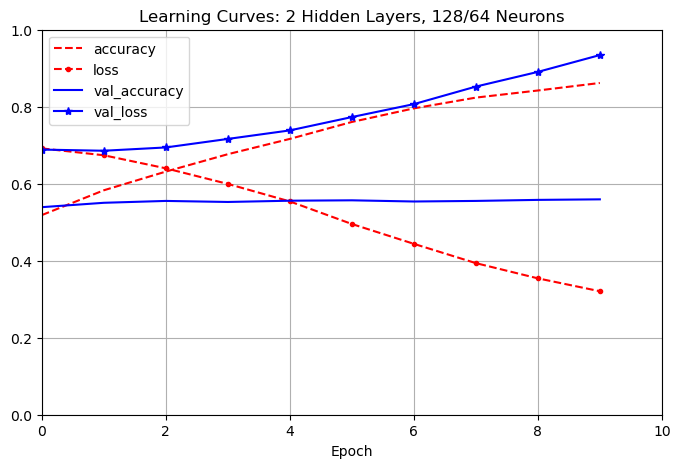

In [202]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0, 10], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--.', 'b-', 'b-*'])
plt.title('Learning Curves: 2 Hidden Layers, 128/64 Neurons')
plt.show()

In [ ]:
# Compute 52-week moving average and percent undervalued/overvalued

# 52-week (approx. 252 trading days) moving average
prices_df['52wk_ma'] = prices_df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=252, min_periods=20).mean())

# Create new feature: percent_diff_from_52wk_avg = (close - 52wk_ma) / 52wk_ma
prices_df['percent_from_52wk_avg'] = (prices_df['close'] - prices_df['52wk_ma']) / prices_df['52wk_ma']

# Get previous Friday's close for each open_date_used
merged['prev_friday'] = pd.to_datetime(merged['open_date_used']) - pd.to_timedelta(pd.to_datetime(merged['open_date_used']).dt.weekday + 3, unit='D')
merged = merged.merge(
    prices_df[['ticker', 'date', 'percent_from_52wk_avg']],
    left_on=['ticker', 'prev_friday'],
    right_on=['ticker', 'date'],
    how='left'
)

# Clean up merged dataframe
merged = merged.rename(columns={'percent_from_52wk_avg': 'valuation_feature'})
merged.drop(columns=['date'], inplace=True)

### Repeat Random Forest Classifier training using daily headline data

Create a new `merged_1day` dataframe that contains each trading day's close, the previous day's close, and the previous day's headlines.

In [ ]:
# normalize dates to remove time & timezone info
news_1day = news_df.copy()
news_1day['date'] = pd.to_datetime(news_1day['date'], utc=True)
news_1day['date'] = news_1day['date'].dt.tz_localize(None).dt.normalize()

# ensure price dates are also normalized
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df['date'] = prices_df['date'].dt.normalize()

# limit news to same range as prices
min_price_date = prices_df['date'].min()
max_price_date = prices_df['date'].max()

news_1day = news_1day[
    (news_1day['date'] >= min_price_date) &
    (news_1day['date'] <= max_price_date)
]

# get previous trading day per ticker
# sort and shift to get the previous trading day for each ticker
prices_1day = prices_df[['ticker', 'date', 'close']].copy()
prices_1day = prices_1day.sort_values(['ticker', 'date'])
prices_1day['prev_trading_date'] = prices_1day.groupby('ticker')['date'].shift(1)

# merge with news from the previous trading day
merged_with_news = pd.merge(
    prices_1day,
    news_1day[['ticker', 'date', 'headline']],
    left_on=['ticker', 'prev_trading_date'],
    right_on=['ticker', 'date'],
    how='left'
)

# rename to avoid confusion
news_with_price = merged_with_news.rename(columns={
    'date_x': 'date',            # trading date
    'date_y': 'headline_date'    # date of the news
})

In [ ]:
# aggregate headlines per (ticker, trading day)
headline_agg = news_with_price.groupby(['ticker', 'date'])['headline'] \
    .apply(lambda x: " ".join(x.dropna())).reset_index()

# merge aggregated headlines back with prices_1day
merged_1day = pd.merge(
    prices_1day,
    headline_agg,
    on=['ticker', 'date'],
    how='left'
).rename(columns={'headline': 'headlines_prev_day'})

# add target column: UP or DOWN
# get previous day close for each ticker
merged_1day = merged_1day.sort_values(['ticker', 'date'])
merged_1day['prev_close'] = merged_1day.groupby('ticker')['close'].shift(1)

# create target column
merged_1day['target'] = np.where(
    merged_1day['close'] > merged_1day['prev_close'],
    'UP', 'DOWN'
)

# reorder columns for clarity
merged_1day = merged_1day[['ticker', 'date', 'prev_trading_date', 'prev_close', 'headlines_prev_day', 'close', 'target']]

# drop rows without headlines
merged_1day = merged_1day[
    merged_1day['headlines_prev_day'].fillna('').str.strip() != ''
]

# reset index
merged_1day.reset_index(drop=True, inplace=True)

In [ ]:
# clean and lemmatize headlines
merged_1day['headlines_prev_day_clean'] = merged_1day['headlines_prev_day'].apply(clean)

merged_1day.head()

In [ ]:
# vectorize cleaned 1 day headlines
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=5000) 
X_text_1d = tfidf.fit_transform(merged_1day['headlines_prev_day_clean'])

In [ ]:
# train randomforest classifier and measure train time
start = time.time()

X_1d = X_text_1d
y_1d = merged_1day['target']

# Save original indices
original_indices_1d = merged_1day.index

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_1d, y_1d, original_indices_1d, test_size=0.2, random_state=42)

print("Training model...")
clf_1d = RandomForestClassifier(n_estimators=500, random_state=42)
clf_1d.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

In [ ]:
y_pred = clf_1d.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# get predicted probabilities of going 'UP'
y_proba = clf_1d.predict_proba(X_test)
proba_up = y_proba[:, 1]

# create dataframe to assess top predictions
results = pd.DataFrame({
    'ticker': merged_1day.loc[test_idx, 'ticker'].values,
    'prob_up': proba_up,
    'true_label': y_test,
    'headline': merged_1day.loc[test_idx, 'headlines_prev_day_clean'].values
})

# find top 20 most confident predictions for 'UP'
top_20_up = results.sort_values('prob_up', ascending=False).head(20)
print(top_20_up[['ticker', 'true_label', 'prob_up', 'headline']])

In [ ]:
# Find top 10 likeliest stocks to go up on a given day

# Step 1: set target day
target_day = pd.to_datetime("2016-09-06")
target_day_data = merged_1day[merged_1day['date'] == target_day]

# Step 2: Get the subset of test data from merged that matches this latest date
# Filter merged rows that are both in the test set and match the latest date
target_day_test_mask = target_day_data.index.isin(test_idx)
target_day_test = target_day_data[target_day_test_mask]

# Step 4: Get predictions for those test rows
X_target = tfidf.transform(target_day_test['headlines_prev_day'])
pred_probs = clf_1d.predict_proba(X_target)  # Assuming binary classification with 'DOWN' and 'UP'
up_probs = pred_probs[:, list(clf_1d.classes_).index('UP')]  # Probabilities of going UP

# Step 5: Add predictions back to the test DataFrame
target_day_test = target_day_test.copy()
target_day_test['prob_up'] = up_probs

# Step 6: Sort by probability of going up and select top 10
top_10 = target_day_test.sort_values('prob_up', ascending=False).head(10)

# Display the top 10 likeliest stocks to go up on that trading day
print(top_10[['ticker', 'date', 'prob_up']])

In [ ]:
# assess predictive performance

# Make a copy of the top_10 predictions
top_10_eval = top_10.copy()

# Calculate absolute price change
top_10_eval['abs_price_change'] = (top_10_eval['close'] - top_10_eval['prev_close'])

# Calculate percentage change
top_10_eval['pct_price_change'] = ((top_10_eval['close'] - top_10_eval['prev_close']) / top_10_eval['prev_close']) * 100

# Display relevant columns
print(top_10_eval[['ticker', 'date', 'prev_close', 'close', 'abs_price_change', 'pct_price_change', 'prob_up']])